# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

In [7]:
# probably the same list in alphabetic order may be useful later:

print (sorted(training.words, key = str.lower))

['ALL', 'ANN', 'APPLE', 'ARRIVE', 'BILL', 'BLAME', 'BLUE', 'BOOK', 'BORROW', 'BOX', 'BOY', 'BREAK-DOWN', 'BROCCOLI', 'BROTHER', 'BUT', 'BUY', 'BUY1', 'CAN', 'CANDY', 'CAR', 'CHICAGO', 'CHICKEN', 'CHINA', 'CHOCOLATE', 'COAT', 'CORN', 'CORN1', 'DECIDE', 'EAT', 'FIND', 'FINISH', 'FISH', 'FRANK', 'FRED', 'FRIEND', 'FUTURE', 'FUTURE1', 'GET', 'GIRL', 'GIVE', 'GIVE1', 'GIVE2', 'GIVE3', 'GO', 'GO1', 'GO2', 'GROUP', 'HAVE', 'HERE', 'HIT', 'HOMEWORK', 'HOUSE', 'IX', 'IX-1P', 'JANA', 'JOHN', 'KNOW', 'LAST-WEEK', 'LEAVE', 'LEG', 'LIKE', 'LIVE', 'LOVE', 'MAN', 'MANY', 'MARY', 'MOTHER', 'MOVIE', 'NAME', 'NEW', 'NEW-YORK', 'NEXT-WEEK', 'NOT', 'OLD', 'PARTY', 'PAST', 'PEOPLE', 'POSS', 'POTATO', 'PREFER', 'PUTASIDE', 'READ', 'SAY', 'SAY-1P', 'SEARCH-FOR', 'SEE', 'SELF', 'SELL', 'SHOOT', 'SHOULD', 'SOMETHING-ONE', 'STOLEN', 'STUDENT', 'SUE', 'TEACHER', 'TELL', 'THINK', 'THROW', 'TOMORROW', 'TOY', 'TOY1', 'VEGETABLE', 'VIDEOTAPE', 'VISIT', 'WANT', 'WHAT', 'WHO', 'WILL', 'WOMAN', 'WONT', 'WRITE', 'YESTER

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [8]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [9]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [11]:
from asl_utils import test_std_tryit
df_std = asl.df.groupby('speaker').std()  # pandas-style st.deviation - not numpy!

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [12]:
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['speaker'].map(df_means['right-x']))/asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['speaker'].map(df_means['right-y']))/asl.df['speaker'].map(df_std['right-y'])
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['speaker'].map(df_means['left-x']))/asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['speaker'].map(df_means['left-y']))/asl.df['speaker'].map(df_std['left-y'])

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [13]:
asl.df['polar-lr'] = np.sqrt((asl.df['grnd-lx'])**2 + (asl.df['grnd-ly'])**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

asl.df['polar-rr'] = np.sqrt((asl.df['grnd-rx'])**2 + (asl.df['grnd-ry'])**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [14]:
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)

asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [15]:
asl.df['normgrnd-rx'] = (asl.df['grnd-rx'] - asl.df['speaker'].map(df_means['grnd-rx']))/asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['normgrnd-ry'] = (asl.df['grnd-ry'] - asl.df['speaker'].map(df_means['grnd-ry']))/asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['normgrnd-lx'] = (asl.df['grnd-lx'] - asl.df['speaker'].map(df_means['grnd-lx']))/asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['normgrnd-ly'] = (asl.df['grnd-ly'] - asl.df['speaker'].map(df_means['grnd-ly']))/asl.df['speaker'].map(df_std['grnd-ly'])

In [16]:
features_custom1 = ['normgrnd-rx', 'normgrnd-ry', 'normgrnd-lx', 'normgrnd-ly']

For rescaling polar coordinates, I'll need max and min values:

In [17]:
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()

In [18]:
# rescaled polar:
asl.df['rsp-rr'] = (asl.df['polar-rr'] - asl.df['speaker'].map(df_mins['polar-rr']))/(asl.df['speaker'].map(df_maxs['polar-rr']) - asl.df['speaker'].map(df_mins['polar-rr']))

asl.df['rsp-lr'] = (asl.df['polar-lr'] - asl.df['speaker'].map(df_mins['polar-lr']))/(asl.df['speaker'].map(df_maxs['polar-lr']) - asl.df['speaker'].map(df_mins['polar-lr']))

pi = 3.14159265358979
asl.df['rsp-rtheta'] = pi*(asl.df['polar-rtheta'] - asl.df['speaker'].map(df_mins['polar-rtheta']))/(asl.df['speaker'].map(df_maxs['polar-rtheta']) - asl.df['speaker'].map(df_mins['polar-rtheta']))

asl.df['rsp-ltheta'] = pi*(asl.df['polar-ltheta'] - asl.df['speaker'].map(df_mins['polar-ltheta']))/(asl.df['speaker'].map(df_maxs['polar-ltheta']) - asl.df['speaker'].map(df_mins['polar-ltheta']))

features_custom2 = ['rsp-rr', 'rsp-lr', 'rsp-rtheta', 'rsp-ltheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** In fact, I have two custom feature lists. Both try to standardize movements of a speaker within their own typical limits. For grnd -x/y the procedure is exactly the same as for norm -x/y. For polar coordinates, I rescale them. Later (when we calculate the error on the test set ), I'll be able to say - WHY?! I see just one reason to create new features - if they improve prediction accuracy. At this stage, I have no meaningful answer about WHY?! It just seems reasonable to get rid of individual variations.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [19]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [20]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.011s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [21]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


In [22]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [23]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 3
hidden state #0
mean =  [  -6.           91.22222222   72.44444444  111.22222222]
variance =  [ 79.77888889   5.9517284    6.91469136   0.84061728]

hidden state #1
mean =  [   3.49557178   67.06601017   17.97370893  148.17496096]
variance =  [  65.5396367   336.0411958    80.08946698  288.37092735]

hidden state #2
mean =  [   5.03409238   69.22542414   -0.86228987  102.70634665]
variance =  [ 117.81469271  320.42473069   93.64499563  346.2557283 ]

logL = -2512.6946645324856


In [24]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [   6.39637775   52.16647231   -1.31524946  120.62716926]
variance =  [ 19.53083468  10.85394979  16.35743119  39.85954619]

hidden state #1
mean =  [   9.17236619   46.8796207    16.21854666  139.06389474]
variance =  [ 27.56272856  38.99065774  14.09833405  20.26763429]

hidden state #2
mean =  [  -6.           91.22222222   72.44444444  111.22222222]
variance =  [ 79.77888889   5.9517284    6.91469136   0.84061728]

hidden state #3
mean =  [   1.06666667   80.2          19.2         177.93333333]
variance =  [ 17.26288889  46.82733333  74.42733333   3.79622222]

hidden state #4
mean =  [ 11.55527641  59.50010785  -6.90871355  73.08025831]
variance =  [ 12.57160161  11.93442338  31.53329998  42.09642477]

hidden state #5
mean =  [  -4.07753854   80.03334361    7.39405188  134.28603654]
variance =  [  41.20149152  139.57377674    4.43293087   32.29343189]

hidden state #6
mean =  [  -3.64361425   92.22943683   -7

A slight improvement in logL - thanks to increased complexity of the model. Same excercise for other feature sets:

In [25]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_norm) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [ 0.51125397  0.0286681  -0.28431697  0.21524108]
variance =  [ 0.05819257  0.13732115  0.00288019  0.01973527]

hidden state #1
mean =  [ 1.49425102  0.0658835  -1.89518962 -1.15017649]
variance =  [ 0.02606749  0.00953747  0.04098331  0.01419231]

hidden state #2
mean =  [ 1.30735484 -0.20053145  0.01838407 -0.70384698]
variance =  [ 0.09210144  0.01083577  0.15252617  0.19719848]

hidden state #3
mean =  [ 0.59265505 -0.16056647  2.56445951 -1.57242708]
variance =  [ 0.18459494  0.00310984  0.00541168  0.0012982 ]

hidden state #4
mean =  [ 1.34385625 -0.19770765 -0.94113235  0.38072248]
variance =  [ 0.04622422  0.01918219  0.01423646  0.0613482 ]

hidden state #5
mean =  [ 1.60988823 -0.07353187 -1.1734314  -1.42845147]
variance =  [ 0.01842362  0.00571976  0.30734141  0.08164625]

hidden state #6
mean =  [-0.1265868  -0.54310068  0.36556533 -0.25389142]
variance =  [ 0.11092673  0.01143707  0.04084044  0.093

In [26]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_polar) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [  9.18635849e+01  -6.68046993e-02   1.32750054e+02   5.77137281e-01]
variance =  [  4.30510045e+00   1.07658700e-02   3.75763837e+00   1.33915082e-03]

hidden state #1
mean =  [  6.01198626e+01   7.09685033e-02   8.45522005e+01  -4.78877643e-02]
variance =  [  8.37125757e+01   5.98096675e-03   2.76631470e+01   6.92348359e-03]

hidden state #2
mean =  [  4.84792043e+01   2.11108440e-01   1.39794694e+02   1.17405885e-01]
variance =  [  4.07170913e+01   5.94238175e-03   2.34090107e+01   9.77607997e-04]

hidden state #3
mean =  [  8.32231157e+01   1.56255286e-02   1.77864910e+02   8.57142762e-02]
variance =  [  1.46579799e+01   3.47687400e-03   1.73489942e+00   1.30756972e-03]

hidden state #4
mean =  [  4.72840611e+01  -2.40156795e-01   1.15944321e+02   7.74616952e-02]
variance =  [  3.99493487e+01   2.10436072e-02   3.67219945e+02   2.08533995e-03]

hidden state #5
mean =  [  8.57043358e+01   2.27415892e-01   1.068

In [27]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_delta) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [ 2.5958725  -5.40962804 -0.60474145 -0.10715799]
variance =  [  1.4857841   10.6029442    5.86856158   1.39893497]

hidden state #1
mean =  [ 0.          0.          0.02040955  0.        ]
variance =  [ 0.00020409  0.00020409  0.06101483  0.00020409]

hidden state #2
mean =  [ 4.35419126  4.28640277 -1.3067622  -9.43335054]
variance =  [ 5.81463332  4.03419985  4.3170478   4.80471734]

hidden state #3
mean =  [ -1.33333335e+00   1.50293037e-92  -1.20000000e+01  -1.26666667e+01]
variance =  [  3.55888892e+00   3.33333338e-03   6.70000005e-01   2.89222225e+00]

hidden state #4
mean =  [  6.          -6.33333333 -11.33333333 -20.33333333]
variance =  [  2.00333333  10.89222222   0.89222222  13.55888889]

hidden state #5
mean =  [ 4.37932336  3.03349522 -1.00433064  0.79777717]
variance =  [ 10.55060641   6.5731481    2.20015676   5.40292091]

hidden state #6
mean =  [-1.33381664 -1.70522011 -0.66420607  2.1670823 ]

In [28]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_custom1) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [ 1.09031917 -0.14791476 -1.08926234  0.52706879]
variance =  [ 0.05401491  0.01338192  0.05470167  0.00420609]

hidden state #1
mean =  [ 0.66936623  0.04662339  2.73388679 -1.25269845]
variance =  [ 0.19529622  0.00319104  0.03151153  0.00173875]

hidden state #2
mean =  [ 1.26129123 -0.06195261 -1.9211112  -1.40935524]
variance =  [ 0.1047142   0.00417819  0.11297803  0.0777596 ]

hidden state #3
mean =  [ 1.41094254 -0.34976135  0.19706389  0.65097115]
variance =  [ 0.06570716  0.02294305  0.06995659  0.02679053]

hidden state #4
mean =  [ 1.76114086 -0.06322613 -0.82249763 -1.34025449]
variance =  [ 0.09824792  0.00925993  0.01373933  0.0138808 ]

hidden state #5
mean =  [ 1.26710844 -0.10938676 -0.08732469 -0.75716019]
variance =  [ 0.19866413  0.00932492  0.04710666  0.03480122]

hidden state #6
mean =  [ 0.30558655 -0.44399985  0.1609432   0.25667104]
variance =  [ 0.2585172   0.01012572  0.05531183  0.178

In [29]:
my_testword = 'LOVE'
model, logL = train_a_word(my_testword, 11, features_custom2) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for LOVE is 11
hidden state #0
mean =  [ 0.43365895  0.48051129  2.24212046  0.51945048]
variance =  [ 0.00214888  0.00333689  0.00241207  0.00726926]

hidden state #1
mean =  [ 0.28499091  0.82559781  1.58940789  0.72741672]
variance =  [ 0.00215833  0.00173747  0.00482247  0.00377041]

hidden state #2
mean =  [ 0.42648203  0.80561324  2.28812603  0.65488821]
variance =  [ 0.00166291  0.01374634  0.00278304  0.00990245]

hidden state #3
mean =  [ 0.47726687  0.63764823  2.18850579  1.60740499]
variance =  [ 0.00123478  0.00124979  0.01022613  0.00191382]

hidden state #4
mean =  [ 0.45320218  0.35920523  2.369221    0.25936484]
variance =  [ 0.00103063  0.00314387  0.00163866  0.03688616]

hidden state #5
mean =  [ 0.44751719  0.52657547  2.49524866  0.84090352]
variance =  [ 0.00133023  0.00573503  0.00290918  0.00855045]

hidden state #6
mean =  [ 0.48340761  0.80176516  1.45501072  0.56505563]
variance =  [ 0.01149814  0.00144023  0.00191966  0.001

Feature selection matters! (big news, indeed...)

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [30]:
%matplotlib inline

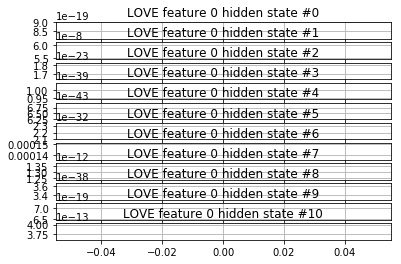

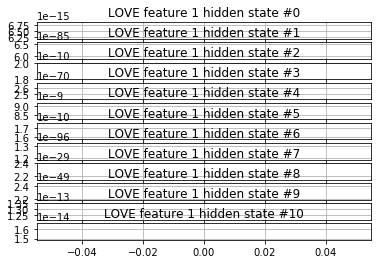

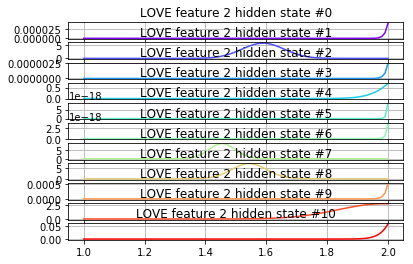

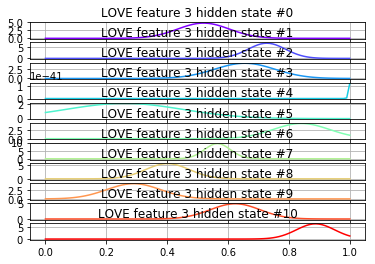

In [31]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [32]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


In [33]:
training = asl.build_training(features_custom1)
word = 'LOVE' 
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for LOVE is 3


In [34]:
training = asl.build_training(features_custom2)
word = 'LOVE' 
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=11).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for LOVE is 11


What is the purpose of the above excercise ? - No idea....

##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [35]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


In [36]:
training = asl.build_training(features_custom1) # Experiment here with different feature sets
word = 'LOVE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 5  6  7  8  9 10 11 12 13] Test fold indices:[0 1 2 3 4]
Train fold indices:[ 0  1  2  3  4 10 11 12 13] Test fold indices:[5 6 7 8 9]
Train fold indices:[0 1 2 3 4 5 6 7 8 9] Test fold indices:[10 11 12 13]


In [37]:
training = asl.build_training(features_custom2) # Experiment here with different feature sets
word = 'LOVE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 5  6  7  8  9 10 11 12 13] Test fold indices:[0 1 2 3 4]
Train fold indices:[ 0  1  2  3  4 10 11 12 13] Test fold indices:[5 6 7 8 9]
Train fold indices:[0 1 2 3 4 5 6 7 8 9] Test fold indices:[10 11 12 13]


What is the purpose of the above excercise ? - No idea....

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [38]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [39]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [40]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.2971741234567901 seconds
Training complete for BOOK with 6 states with time 3.087050271604938 seconds
Training complete for VEGETABLE with 2 states with time 1.369846913580247 seconds
Training complete for FUTURE with 2 states with time 2.89047624691358 seconds
Training complete for JOHN with 12 states with time 28.629359012345677 seconds


An important note. If you have too few observations, you have nothing to coss-validate on. For words like "LIVE" or 'LEG'. The following dictionary (with keys as the words from training and values as number of observations) must be useful:

In [41]:
dictTest = {}
for key in training.get_all_sequences().keys():
    dictTest[key] = len(training.get_all_sequences()[key])
dictTest

{'ALL': 2,
 'ANN': 1,
 'APPLE': 5,
 'ARRIVE': 15,
 'BILL': 6,
 'BLAME': 4,
 'BLUE': 4,
 'BOOK': 18,
 'BORROW': 1,
 'BOX': 5,
 'BOY': 4,
 'BREAK-DOWN': 4,
 'BROCCOLI': 2,
 'BROTHER': 2,
 'BUT': 2,
 'BUY': 16,
 'BUY1': 6,
 'CAN': 17,
 'CANDY': 1,
 'CAR': 16,
 'CHICAGO': 1,
 'CHICKEN': 2,
 'CHINA': 2,
 'CHOCOLATE': 3,
 'COAT': 2,
 'CORN': 3,
 'CORN1': 2,
 'DECIDE': 2,
 'EAT': 5,
 'FIND': 1,
 'FINISH': 5,
 'FISH': 2,
 'FRANK': 4,
 'FRED': 1,
 'FRIEND': 1,
 'FUTURE': 15,
 'FUTURE1': 2,
 'GET': 1,
 'GIRL': 5,
 'GIVE': 9,
 'GIVE1': 6,
 'GIVE2': 1,
 'GIVE3': 2,
 'GO': 12,
 'GO1': 4,
 'GO2': 1,
 'GROUP': 1,
 'HAVE': 5,
 'HERE': 3,
 'HIT': 1,
 'HOMEWORK': 1,
 'HOUSE': 10,
 'IX': 52,
 'IX-1P': 5,
 'JANA': 2,
 'JOHN': 113,
 'KNOW': 3,
 'LAST-WEEK': 1,
 'LEAVE': 3,
 'LEG': 1,
 'LIKE': 12,
 'LIVE': 1,
 'LOVE': 14,
 'MAN': 2,
 'MANY': 1,
 'MARY': 37,
 'MOTHER': 3,
 'MOVIE': 2,
 'NAME': 1,
 'NEW': 5,
 'NEW-YORK': 2,
 'NEXT-WEEK': 1,
 'NOT': 10,
 'OLD': 1,
 'PARTY': 1,
 'PAST': 1,
 'PEOPLE': 4,
 'POSS'

The purpose of the excercise seems clear: to test that SelectorCV works with all possible features. Lets' start (I don't like "JOHN" though - the word has too many observations. I'll use "LOVE" instead...

In [42]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'LOVE']

training = asl.build_training(features_norm)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.29075002469141964 seconds
Training complete for BOOK with 5 states with time 3.263107160493746 seconds
Training complete for VEGETABLE with 15 states with time 1.424592592592603 seconds
Training complete for FUTURE with 2 states with time 3.1436448395061234 seconds
Training complete for LOVE with 4 states with time 3.095310222222224 seconds


In [43]:
training = asl.build_training(features_polar)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.28809797530857395 seconds
Training complete for BOOK with 5 states with time 3.3735996049382493 seconds
Training complete for VEGETABLE with 15 states with time 1.6466164938270822 seconds
Training complete for FUTURE with 2 states with time 3.057040197530796 seconds
Training complete for LOVE with 3 states with time 2.8171681975309184 seconds


In [44]:
training = asl.build_training(features_delta)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.3153880493827046 seconds
Training complete for BOOK with 9 states with time 4.278644543209907 seconds
Training complete for VEGETABLE with 5 states with time 1.4116412839506438 seconds
Training complete for FUTURE with 15 states with time 3.962570271604932 seconds
Training complete for LOVE with 7 states with time 3.5650026666667145 seconds


In [45]:
training = asl.build_training(features_custom1)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.29333175308647697 seconds
Training complete for BOOK with 2 states with time 3.4331571358023893 seconds
Training complete for VEGETABLE with 2 states with time 1.4134909629628964 seconds
Training complete for FUTURE with 4 states with time 3.1483745185184944 seconds
Training complete for LOVE with 2 states with time 3.1811642469136814 seconds


In [46]:
training = asl.build_training(features_custom2)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.2507251358024405 seconds
Training complete for BOOK with 3 states with time 3.235842765432153 seconds
Training complete for VEGETABLE with 5 states with time 1.7032553086419284 seconds
Training complete for FUTURE with 3 states with time 3.5660938271605573 seconds
Training complete for LOVE with 2 states with time 2.8908523456790363 seconds


Nice! it all worked fine. Different feature sets produce HMM with different number of states for a particular word.

In [47]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.26715417283946863 seconds
Training complete for BOOK with 8 states with time 1.5887146666666467 seconds
Training complete for VEGETABLE with 9 states with time 0.5631715555555274 seconds
Training complete for FUTURE with 9 states with time 1.677695999999969 seconds
Training complete for LOVE with 8 states with time 1.2716859259260218 seconds


In [48]:
training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.2805787654320966 seconds
Training complete for BOOK with 5 states with time 1.560349629629627 seconds
Training complete for VEGETABLE with 5 states with time 0.6405289876543065 seconds
Training complete for FUTURE with 7 states with time 1.8434378271604146 seconds
Training complete for LOVE with 7 states with time 1.7254739753086596 seconds


In [49]:
training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.28809520987647375 seconds
Training complete for BOOK with 7 states with time 1.945874172839467 seconds
Training complete for VEGETABLE with 3 states with time 0.7990763456789409 seconds
Training complete for FUTURE with 4 states with time 1.6297548641975936 seconds
Training complete for LOVE with 7 states with time 1.8404298271605057 seconds


In [50]:
training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.2929540740740322 seconds
Training complete for BOOK with 8 states with time 2.3969619753086135 seconds
Training complete for VEGETABLE with 3 states with time 0.7018338765433327 seconds
Training complete for FUTURE with 5 states with time 1.5863079506170834 seconds
Training complete for LOVE with 5 states with time 1.9256892839505326 seconds


In [51]:
training = asl.build_training(features_custom1)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.282507851851733 seconds
Training complete for BOOK with 7 states with time 1.6118597530864918 seconds
Training complete for VEGETABLE with 5 states with time 0.6182008888890778 seconds
Training complete for FUTURE with 5 states with time 1.7811365925924747 seconds
Training complete for LOVE with 6 states with time 1.765632000000096 seconds


In [52]:
training = asl.build_training(features_custom2)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.21928098765442883 seconds
Training complete for BOOK with 5 states with time 1.710550518518403 seconds
Training complete for VEGETABLE with 3 states with time 1.1613522962963998 seconds
Training complete for FUTURE with 5 states with time 1.507519209876591 seconds
Training complete for LOVE with 8 states with time 1.563510913580103 seconds


Everything worked fine again!

In [53]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.6730477037037872 seconds
Training complete for BOOK with 15 states with time 3.2236942222220932 seconds
Training complete for VEGETABLE with 15 states with time 2.400295901234358 seconds
Training complete for FUTURE with 15 states with time 3.391635753086348 seconds
Training complete for LOVE with 15 states with time 2.879030518518448 seconds


In [54]:
training = asl.build_training(features_norm) 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.9760944197530534 seconds
Training complete for BOOK with 15 states with time 3.171695012345708 seconds
Training complete for VEGETABLE with 5 states with time 2.3768999506173714 seconds
Training complete for FUTURE with 15 states with time 3.433251950617432 seconds
Training complete for LOVE with 14 states with time 3.503626271604844 seconds


In [55]:
training = asl.build_training(features_polar) 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 2.2107895308643037 seconds
Training complete for BOOK with 13 states with time 3.5832525432099374 seconds
Training complete for VEGETABLE with 12 states with time 2.6778026666665937 seconds
Training complete for FUTURE with 14 states with time 3.303576098765461 seconds
Training complete for LOVE with 15 states with time 3.3339030123456723 seconds


In [56]:
training = asl.build_training(features_delta) 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.5701080493827249 seconds
Training complete for BOOK with 13 states with time 3.9636519506173045 seconds
Training complete for VEGETABLE with 2 states with time 2.4515784691359386 seconds
Training complete for FUTURE with 5 states with time 2.070451358024684 seconds
Training complete for LOVE with 14 states with time 3.567813135802453 seconds


In [59]:
training = asl.build_training(features_custom1) 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.876449185185038 seconds
Training complete for BOOK with 15 states with time 3.2237183209877003 seconds
Training complete for VEGETABLE with 9 states with time 2.316696888889055 seconds
Training complete for FUTURE with 15 states with time 3.4024967901234504 seconds
Training complete for LOVE with 14 states with time 3.342607407407286 seconds


In [58]:
training = asl.build_training(features_custom2) 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.7882433580246015 seconds
Training complete for BOOK with 14 states with time 3.2594113580246358 seconds
Training complete for VEGETABLE with 3 states with time 2.8345414320986038 seconds
Training complete for FUTURE with 15 states with time 3.1275433086418616 seconds
Training complete for LOVE with 15 states with time 3.1631707654321417 seconds


The good news: everything went without a hitch!

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** OK. Again, I must repeat myself: I can see only one reason to prefer any selector over the other - on the bases of how well they train, i.e. which accuracy they produce on the test set (= set of new data which the algorithm has never seen before). At this stage I can discard SelectorConstant which, in effect, is not a selector...

SelectorDIC seems to work somewhat slower but if it gives a better accuracy, maybe it is a good deal to spend more time for better accuracy?

The rubrick demands "a brief but thoughtful comparison of the selectors", though... All three selectors use different criterea for selecting the best model ( which is determined by the number of hidden states in the HMM). Which is best? Lets' experiment and see (end of Part 3 of this notebook) - no more thoughtful thoughts....Sorry.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [60]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 37.002s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [62]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


In [63]:
models = train_all_words(features_custom2, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


In [64]:
models = train_all_words(features_polar, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


Again, what was the purpose og the above excercise ? no idea...

##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [65]:
# Eventually!

test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [66]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [67]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

Very instructive! The non-selecting selector spits out WER = 66.85%. Probably, this is the worst case. From now on I'll focus on three other selectors.

One note from the very beginning. As cusom1 and custom2 feature sets are naturally derived from norm and polar, it seems reasonable to compare results within these pairs. But first, I'll start from the feature set which seems least promising - delta. In fact, without time wrap it seems hopeless.

In [68]:
features = features_delta 
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX *GO1                                                 JOHN WRITE HOMEWORK
    7: JOHN *HAVE *GIVE1 *TEACHER                                    JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *JOHN *LOVE *JOHN *CAR *GO *MARY *JOHN                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *JOHN IX *MARY                                     JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   36: *JOHN *JOHN *IX IX *MARY *MARY                                MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

In [69]:
features = features_delta 
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *LOVE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *STUDENT *GIVE1 *STUDENT                                 JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *CAR *TOMORROW *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

In [70]:
features = features_delta 
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *GIVE1 *GIVE1 *ARRIVE                                    JOHN CAN GO CAN
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *HOUSE *FUTURE *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHOULD *JOHN IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

As expected, the results disappoint: WER is always worse than 60%. Now let's look at the raw data (ground):

In [71]:
features = features_ground 
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *COAT *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: *IX CAN *CAN CAN                                              JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *JOHN *TELL *CAR *CAR *CHICAGO *BROTHER       JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL IX *TELL IX                                        JOHN LIKE IX IX IX
   28: JOHN *TELL IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *JANA *BILL *FUTURE1 *JANA *IX                                JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [72]:
features = features_ground 
model_selector = SelectorBIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 GO *ARRIVE                                JOHN CAN GO CAN
   12: *IX *WHAT *CAN CAN                                            JOHN CAN GO CAN
   21: JOHN *WRITE *JOHN *FUTURE *CAR *TEACHER *VISIT *WHO           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *LIKE IX                                          JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE *LOVE                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT *VISIT *IX *GIVE *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE            

In [74]:
features = features_ground 
model_selector = SelectorDIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

Great! All three selectors produce WER lower than 60%! The best result - SelectorCV with 54.49%. Can normalization help? (norm and custom1):

In [75]:
features = features_norm
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *HAVE                                              JOHN WRITE HOMEWORK
    7: *SHOOT *NEW *SOMETHING-ONE CAN                                JOHN CAN GO CAN
   12: *IX *HAVE *GO1 CAN                                            JOHN CAN GO CAN
   21: *LIKE *HAVE *HAVE *IX-1P *VISIT *BLAME *CHICKEN *EAT          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   28: *ANN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   30: *SHOOT LIKE *LOVE *LIKE IX                                    JOHN LIKE IX IX IX
   36: *SHOOT VEGETABLE *GIVE3 *GIVE2 LIKE *LIKE                     MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *SHOOT *PREFER *VEGETABLE LOVE                           JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE          

In [76]:
features = features_custom1 
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *BUY *MARY CAN                                           JOHN CAN GO CAN
   12: *IX *HAVE *CAN *HOUSE                                         JOHN CAN GO CAN
   21: JOHN *NEW *HAVE *ANN *HOUSE *CAR *FUTURE *EAT                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *LOVE LIKE *MARY *LIKE *LOVE                                  JOHN LIKE IX IX IX
   28: *LOVE *WOMAN *LOVE *LIKE *LOVE                                JOHN LIKE IX IX IX
   30: JOHN LIKE *LOVE *BILL *LOVE                                   JOHN LIKE IX IX IX
   36: MARY *WHO *YESTERDAY *BILL *BILL *LIKE                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *BILL *JANA *VEGETABLE LOVE                              JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [77]:
features = features_norm
model_selector = SelectorBIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6123595505617978
Total correct: 69 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *NEW GO *WHAT                                           JOHN CAN GO CAN
   12: *MARY *HAVE *GO1 CAN                                          JOHN CAN GO CAN
   21: *MARY *BOX *HAVE *GO *CAR *CAR *CHICKEN *WRITE                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: *IX-1P *IX *MARY IX IX                                        JOHN LIKE IX IX IX
   36: MARY *MARY *YESTERDAY *SHOOT LIKE *IX                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 *VEGETABLE *MARY                         JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [78]:
features = features_custom1 
model_selector = SelectorBIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *BUY GO CAN                                              JOHN CAN GO CAN
   12: *IX *HOUSE *NEW *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *NEW WONT *MARY *HOUSE *CAR *FUTURE *WRITE               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY *GO *MARY IX                                      JOHN LIKE IX IX IX
   28: *MARY *MARY *GO IX *LOVE                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *LOVE IX                                      JOHN LIKE IX IX IX
   36: MARY *NOT *YESTERDAY *TELL *LOVE *IX-1P                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 MARY LOVE                                JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [79]:
features = features_norm
model_selector = SelectorDIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *CAR GO CAN                                             JOHN CAN GO CAN
   12: JOHN *WHAT *ARRIVE CAN                                        JOHN CAN GO CAN
   21: *MARY *JOHN *JOHN *BLAME *CAR *CAR *FUTURE CHICKEN            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   28: *ANN *ANN IX *MARY IX                                         JOHN LIKE IX IX IX
   30: *IX-1P *CHOCOLATE *MARY *LOVE *LOVE                           JOHN LIKE IX IX IX
   36: MARY *MARY *YESTERDAY *SHOOT LIKE *IX                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 *VEGETABLE *MARY                         JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [80]:
features = features_custom1 
model_selector = SelectorDIC 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *JOHN                                            JOHN CAN GO CAN
   12: *WHAT *CAR *JOHN *HOUSE                                       JOHN CAN GO CAN
   21: *MARY *NEW *JOHN *ANN *JOHN *CAR *FUTURE *JOHN                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY IX IX IX                                          JOHN LIKE IX IX IX
   28: *MARY *MARY IX IX IX                                          JOHN LIKE IX IX IX
   30: *IX *MARY *MARY *WOMAN IX                                     JOHN LIKE IX IX IX
   36: *IX *NOT *IX *TELL *LOVE *IX                                  MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SOMETHING-ONE *VISIT *GIVE2 MARY LOVE                        JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE        

Counter-intuitively, nowmalization of movements in x- and y-directions (in various forms) didn't help just 55% for custom1 set of features and DIC selector. Maybe I get more lucky with the polar coordinates and their very close sibling - custom2?

In [81]:
features = features_custom2
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: *MARY WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN CAN *JOHN *TOY                                           JOHN CAN GO CAN
   12: *IX *HOUSE *GO1 CAN                                           JOHN CAN GO CAN
   21: *ANN FISH WONT *JOHN *CAR CAN *CHICKEN CHICKEN                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *JOHN *PAST *ANN *ANN                                    JOHN LIKE IX IX IX
   28: *ANN *JOHN *ANN *ANN *ANN                                     JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *NOT VEGETABLE KNOW *TELL *BILL *MARY                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *BILL *FUTURE1 *SAY *GIVE2                               JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE         

In [82]:
features = features_polar
model_selector = SelectorCV 

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
    2: *FRANK *VIDEOTAPE *NEW                                        JOHN WRITE HOMEWORK
    7: JOHN *HAVE *IX *WHAT                                          JOHN CAN GO CAN
   12: *IX CAN *WHAT CAN                                             JOHN CAN GO CAN
   21: JOHN *NEW *NEW *PREFER *CAR *CAR EAT *FUTURE                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *JOHN *EAT *GIRL *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *FUTURE1 *JOHN *IX                                 JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [83]:
features = features_polar
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *NOT *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [84]:
features = features_custom2
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK *JOHN *TOY                                    JOHN CAN GO CAN
   12: *IX *HOUSE *GO1 CAN                                           JOHN CAN GO CAN
   21: *ANN FISH WONT *MARY *BLAME *PARTY *CHICKEN CHICKEN           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX *MARY *MARY *ANN *ANN                                     JOHN LIKE IX IX IX
   28: *ANN *JOHN *MARY *ANN *LOVE                                   JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY *SAY-1P *GIVE *TELL *MARY *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *BILL *FUTURE1 *SAY *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *GO BUY HOUSE            

In [85]:
features = features_polar
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [86]:
features = features_custom2
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK GO *TOY                                       JOHN CAN GO CAN
   12: *IX *HOUSE *GO1 *HOUSE                                        JOHN CAN GO CAN
   21: *ANN FISH WONT *MARY *GO *PARTY *CHICKEN CHICKEN              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX *MARY *WRITE *ANN *ANN                                    JOHN LIKE IX IX IX
   28: *ANN *GO *WRITE *ANN *JOHN                                    JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY *SAY-1P KNOW *TELL *GO *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GIVE *FUTURE1 *SAY *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

Here it is! WER = 0.5337! The reason to construct feature_custom2 was to improve accuracy. The best selector - DIC!

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** All three selectors produced reasonable results ( less than 60%WER). Unprocessed (ground) features worked best with Selector CV and produced quite respectable WER = 0.545. However, the best reasult (WER = 0.5337) was achived for custom2 feature set (probably, I was lucky to guess the correct features to "engineer" for this task) and SelectorDIC which seems to be the most sophisticated selector I've seen so far.

As for the directions for further improvement, the video lectures mentioned at least two promising ways: context training (which exploits better modelling of output / transition probabilities between the signs fed into HMM and reduces the error by approximately half) and statisticall grammar (which allows the HMM to be biased in favour of more probable combinations of words, I'd even call them collocations, and it reduces the error by another factor of 4). It would be instructive to repeat these results on my own, but the link to SLM data below is broken.

From my point of view, another promising approach is to try and use RNNs (recurrent nets) with LSTM (long-short-term memory) cells in order to capture the effects of context and statisitical grammar, especiall for n-grams with larger n (= 3,4 or may be more?) - seq2seq. I would try if I could, but I see no data (once again the link to SLM data below is broken) In any case, the Rubrick doesn't demand anything in excess of the words, words, words... which I've written enough already, I hope.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [61]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 22.662s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()